# 데이터로 만드는 안전한 고속도로
---

**목차**
1. [도입](#1-도입)
2. [전처리](#2-전처리)
3. [분석](#3-분석)
4. [번외](#4-번외)
5. [결론](#5-결론)

## 1 도입
---

### 1.1 주제
- 고속도로 사고를 구간별로 세분화하여 살펴보고 공통점을 탐색하며 다양한 개선안을 제시하고자 합니다.

### 1.2 선정 배경
현대인의 삶에서 고속도로는 이미 너무도 익숙한 공간이며 우리 팀 역시 관심이 높은 분야였습니다.<br>
때마침 관련 공모전을 알게 되어, 최근 1년간 고속도로 사고를 분석하여 사고 다발 구간을 찾고, 원인을 파악하며,<br>
구체적인 개선안의 제시를 목표로 이번 프로젝트를 진행하게 되었습니다.

### 1.3 활용 데이터 및 참고 문헌
- [한국도로공사 문자정보 제공이력 ('20.08 ~ '21.07)](http://data.ex.co.kr/portal/fdwn/view?type=ETC&num=83&requestfrom=dataset)
- [한국도로공사 도로중심선](http://data.ex.co.kr/portal/fdwn/view?type=ETC&num=S0&requestfrom=dataset)

In [1]:
# 필요한 패키지 및 종속성 설치
import os, subprocess, sys

reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0] for r in reqs.split()]

for package_name in ['plotly']:                                                      # plotly 이미지 내보내기
    if package_name not in installed_packages:
        !pip install -Uq {package_name}

# 패키지 로드
import pandas as pd                                                                  # 데이터 분석
import numpy as np                                                                  # 데이터 분석
import plotly.express as px                                                          # 시각화 - Plotly
import plotly.io as pio                                                                # 시각화 - Plotly
from plotly.subplots import make_subplots                                     # 시각화 - Plotly
from datetime import datetime, timedelta                                      # 공통
import glob, re                                                                         # 공통
from IPython.core.display import display, HTML                               # 공통 - 노트북 너비
from IPython.display import display_html                                       # 공통 - 이미지로 출력

# 전역 설정
display(HTML("<style>.container { width:70% !important; }</style>"))     # 노트북 너비
pio.templates.default = "plotly_dark"                                              # Plotly 테마
px.defaults.color_continuous_scale = px.colors.sequential.Bluered          # Plotly express 기본값
px_labels = {'c_차종': '차종'}                                                          # Plotly 공통 레이블
px_layout = {'title': {'x': 0.5, 'yanchor': 'top', 'y': 0.94},                          # Plotly 레이아웃 스타일
             'width': 950, 'height': 400, 'coloraxis_showscale': False,
             'margin': {'r': 20, 't': 60, 'l': 20, 'b': 20}}
px_legend = {'legend': {'title_text':None, 'xanchor':'right', 'x':1,              # Plotly 범례 스타일
             'yanchor':'top', 'y':1, 'bordercolor':'Gray',
             'borderwidth': 0.5}}

In [2]:
# 사용자 클래스 - 데이터셋
class CustomDataset:
    """
    분석에 사용되는 데이터셋 및 메서드를 갖는 사용자 클래스입니다.
    원본 데이터를 작업 데이터로부터 분리하고, 여러 데이터셋을 한 곳에서 관리하는 장점이 있습니다.
    """

    def __init__(self, title=None):
        self.title = title
        self.bins = {}
        self.bin_labels = {}
    
    def get(self, dname=None):
        """데이터셋을 이름으로 검색하여 반환합니다."""
        return self.bins.get(dname, None)
        
    def list(self):
        """데이터셋 이름 목록을 출력합니다."""
        return self.bin_labels

    def update_dataset(self, dname=None, dataset=None, description=None):
        """데이터셋을 업데이트합니다."""
        self.bins.update({dname: dataset})
        self.bin_labels.update({dname: description})
        return len(dataset)
    
    def drop(self, dname=None):
        """데이터셋을 삭제합니다."""
        self.bins.pop(dname, None)
        self.bin_labels.pop(dname, None)
        return None

# 사용자 클래스 - 공통
class CustomUtils:
    """
    자주 사용되는 메소드를 담은 사용자 클래스입니다.
    """
    
    @classmethod
    def display_htmls(_cls, *args, direction='h'):
        """복수의 html을 한 행에 출력합니다."""
        display_style = direction=='h' and 'flex' or 'block'
        html_str = f'<div style="display:{display_style};justify-content:space-around;align-items:center;">'
        for html_src in args:
            html_str += '<div>' + html_src + '</div>'
        html_str += '</div>'
        display_html(html_str, raw=True)
    
    @classmethod
    def jpeg_binary_to_img_src(_cls, jpeg_binary=None):
        """바이너리 타입의 이미지 데이터를 받아 img tag롤 반환합니다."""
        from binascii import b2a_base64
        
        b64_data = b2a_base64(jpeg_binary).decode('ascii')
        return f"<img src='data:image/jpeg;base64,{b64_data}'>"

    @classmethod
    def convert_road_no_from_sms_to_clor(_cls, road_no=None):
        """문자전송내역의 도로번호를 받아 도로중심선의 도로번호를 반환합니다.
            노선명(문자정보 도로번호 -> 도로중심선 도로번호)
            - 변환 불요 : 경부(0010), 광대(0120), 서해안(0150), 울산(0160), 평택제천(0400), 중부내륙(0450),
                          영동(0500), 중앙(0550), 수도권1순환(1000), 남해2지(1040), 서천공주(1510),
                          호남지(2510), 중부내륙지(4510), 중앙지(5510)
            - 변환 필요 : 남해(0100 -> 0102), 고창담양(0140 -> 2530), 평택파주(0170 -> 0171), 새만금포항(0200 -> 0207),
                          익산장수(0201 -> 0205), 호남(0251 -> 0250), 논산천안(0252 -> 0251), 청주영덕(0300 -> 0303),
                          당진대전(0301 -> 0305), 통영대전(0351 -> 0350), 중부(0352 -> 0350), 동해부울(0651 -> 0655),
                          동해울포(0652 -> 0655), 제2경인(1100 -> 1101), 평택화성(1710 -> 171)
            - 변환 불가 : 남해3지(0105 -> 없음), 함양울산(0141 -> 없음), 평택시흥(0153 -> 없음), 중앙부산대구(0552 -> 없음),
                          상주영천(3010 -> 없음), 수도권제2인천김포(4001 -> 없음)
        """
        road_no_mapper = {'0100': '0102', '0105': None, '0140': '2530', '0141': None, '0153': None, '0170': '0171',
                          '0200': '0207', '0201': '0205', '0251': '0250', '0252': '0251', '0300': '0303',
                          '0301': '0305', '0351': '0350','0352': '0350', '0552': None, '0651': '0655',
                          '0652': '0655', '1100': '1101', '1710': '171', '3010': None, '4001': None}
        return road_no_mapper.get(road_no, road_no)

    @classmethod
    def fix_road_name_in_clor(_cls, road_name=None):
        """도로중심선 데이터의 노선명을 받아 정정된 노선명으로 반환합니다.
        """
        road_name_mapper = {'평택화성선': '평택파주선', '논산천안선/호남선': '호남선', '호남선': '논산천안선'}
        return road_name_mapper.get(road_name, road_name)

In [3]:
###
### 데이터 로드 및 전처리
###

is_force_rebuild = False

# 1) 도로중심선 - 한국도로공사
c_filename = 'data/c_도로중심선.csv'
if not is_force_rebuild and os.path.isfile(c_filename):
    _clor_df = pd.read_csv(c_filename, dtype={'노선번호': object})
else:
    raw_filename = 'data/raw/ETC_S0_07_04_295113.csv'
    _clor_df = pd.read_csv(raw_filename, encoding='euc-kr', dtype={'노선번호': object})
    _clor_df.to_csv(c_filename, encoding='utf-8', index=False)

# 2) 문자정보 제공이력 - 한국도로공사
c_filename = 'data/c_주요문자정보제공이력_202008_202107.csv'
if not is_force_rebuild and os.path.isfile(c_filename):
    _sms_sent_df = pd.read_csv(c_filename, dtype={'발생일자': object, '노선번호': object, 'c_시간대': object, 'c_노선번호(도로중심선)': object},
                                        parse_dates=['c_발생일시'])
else:
    _sms_sent_df = None
    mapper_day = {'Monday': '월요일', 'Tuesday': '화요일','Wednesday': '수요일', 'Thursday': '목요일',
                  'Friday': '금요일','Saturday': '토요일','Sunday': '일요일' }

    def get_lat_lon_rname_by_rno_rdist(road_no=None, road_distance=None):
        clor = _clor_df[(_clor_df['노선번호'] == road_no) & (_clor_df['이정'] == road_distance)]
        lat, lon, road_name = tuple(clor[['X좌표값', 'Y좌표값', '도로명']].iloc[0].values) if len(clor) else (None, None, None)
        road_name = CustomUtils.fix_road_name_in_clor(road_name)
        return lat, lon, road_name
    
    def prep_record(record):
        # 구간 데이터 복원 (구간 데이터가 문자내용에 들어간 경우)
        record['구간'] = record['구간'] or record['문자내용']
        road_distance = re.findall('[\w\d()]+[ (]+([\d.]+)', str(record['구간']))
        record['c_이정중심'], record['c_이정시작'], record['c_이정종료'] = None, None, None
        if len(road_distance) == 1:
            # 구간값이 1건(지점)
            record['c_이정중심'] = round(float(road_distance[0]), 1)
            record['c_이정시작'] = record['c_이정중심']
            record['c_이정종료'] = record['c_이정중심']
        elif len(road_distance) == 2:
            # 구간값이 2건(범위)
            road_distances = [float(s) for s in road_distance]
            record['c_이정중심'] = round(np.mean(road_distances), 1)
            record['c_이정시작'] = round(min(road_distances), 1)
            record['c_이정종료'] = round(max(road_distances), 1)

        record['c_노선번호(도로중심선)'] = CustomUtils.convert_road_no_from_sms_to_clor(record['노선번호'])
        record['c_위도'], record['c_경도'], record['c_도로명'] = get_lat_lon_rname_by_rno_rdist(record['c_노선번호(도로중심선)'], record['c_이정중심'])
        record['c_발생일시'] = datetime.strptime(f"{record['발생일자']} {record['발생시간']}", '%Y%m%d %H:%M:%S')
        record['c_요일'] = mapper_day.get(record['c_발생일시'].day_name())
        record['c_주중주말'] = record['c_요일'] in ['토요일', '일요일'] and '주말' or '주중'
        record['c_시간대'] = record['c_발생일시'].hour // 4 * 4
        return record

    # [전처리]
    # 1) 사용하지 않는 '정체길이', '최대' 열 제외
    # 2) 돌발상태 중 '강설,강우,강풍,결빙,노면결빙,노면습기,안개,어는비,적설,차량증가/정체,고장,사고,역주행,작업,장애물,터널내보행자'만 선별
    # 3) 구간 데이터 복원 : 구간 데이터가 '구간' 열이 아닌 '문자내용'에 있을 경우, '문자내용'에서 추출
    # 3) 노선번호 변환
    # 4) 사용자 컬럼 생성

    # 2008(_758476), 2009(_639728), 2010(_181493), 2011(_487777), 2012(_368755), 2101(_339548),
    # 2102(_378612), 2103(_580004), 2104(_963530), 2105(_243354), 2106(_245124), 2107(_943876)
    raw_filenames = glob.glob('data/raw/ETC_83_04_*.csv')
    for raw_filename in raw_filenames:
        loaded_df = pd.read_csv(raw_filename, encoding='cp949', usecols=[0, 1, 2, 3, 4, 5, 8, 9], dtype={'발생일자': object, '노선번호': object})
        events_list = '강설,강우,강풍,결빙,노면결빙,노면습기,안개,어는비,적설,차량증가/정체,고장,사고,역주행,작업,장애물,터널내보행자'.split(',')
        loaded_df = loaded_df[loaded_df['돌발진행상태구분명'].isin(events_list)]
        _sms_sent_df = pd.concat([_sms_sent_df, loaded_df], ignore_index=True) if isinstance(_sms_sent_df, pd.DataFrame) else loaded_df

    _sms_sent_df.dropna(subset=['노선번호', '문자내용'], axis=0, inplace=True)                # 사용자 컬럼 생성 전에 Nan 제거
    _sms_sent_df = _sms_sent_df.apply(prep_record, axis=1).dropna().drop_duplicates(subset=['노선번호', '구간', 'c_발생일시']).sort_values(['c_발생일시'])
    # 관찰구간 컬럼 추가
    interval_km = 1                                                                                            # 구간 단위 거리
    max_distance = _sms_sent_df['c_이정중심'].max()
    bins = range(0, int(max_distance) + interval_km, interval_km)
    bins_label = [f"{bin}, {bin + interval_km - 0.1}" for bin in bins]
    _sms_sent_df['c_관찰구간'] = pd.cut(_sms_sent_df['c_이정중심'], bins, right=False, labels=bins_label[:-1])

    # 컬럼 순서 정렬
    column_names = ['발생일자', '발생시간', '노선번호', '기점종점방향구분명', '구간', '문자내용', '돌발진행상태구분명',
                    '돌발진행상태구분코드', 'c_발생일시', 'c_요일', 'c_주중주말', 'c_시간대', 'c_노선번호(도로중심선)',
                    'c_도로명', 'c_이정중심', 'c_이정시작', 'c_이정종료', 'c_관찰구간', 'c_위도', 'c_경도']
    _sms_sent_df = _sms_sent_df.reindex(columns=column_names)
    _sms_sent_df.to_csv(c_filename, encoding='utf-8', index=False)


# 3) 사고 건 별 데이터
# "문자정보 제공이력 - 한국도로공사" 데이터 중 사고 처리 완료 데이터만 선별합니다.
c_filename = 'data/c_완료기준사고내역_202008_202107.csv'
if not is_force_rebuild and os.path.isfile(c_filename):
    _accidents_df = pd.read_csv(c_filename, dtype={'발생일자': object, '노선번호': object, 'c_시간대': object, 'c_노선번호(도로중심선)': object},
                                         parse_dates=['c_발생일시'])
else:
    def prep_record(record):
        # 문자 내용에서 사고 차종 유추. 없으면 None
        for v_type in ['승용', '화물', '버스']:
            if record['문자내용'] and v_type in record['문자내용']:
                record['c_차종'] = v_type
        return record

    # [전처리]
    # 1) 사고 데이터만 선별 : '돌발진행상태구분명'이 '사고'이고, '문자내용'에 '사고' 단어가 포함 된 데이터
    _accidents_df = _sms_sent_df[(_sms_sent_df['돌발진행상태구분명'] == '사고') & (_sms_sent_df['문자내용'].str \
                         .contains(r'사고[ ]*처리[ ]*완료[ ]*', regex=True))].dropna(axis=0).reset_index(drop=True).apply(prep_record, axis=1)
    # 컬럼 순서 정렬
    column_names = ['발생일자', '발생시간', '노선번호', '기점종점방향구분명', '구간', '문자내용', '돌발진행상태구분명',
                    '돌발진행상태구분코드', 'c_발생일시', 'c_요일', 'c_주중주말', 'c_시간대', 'c_노선번호(도로중심선)',
                    'c_차종', 'c_도로명', 'c_이정중심', 'c_이정시작', 'c_이정종료', 'c_관찰구간', 'c_위도', 'c_경도']
    _accidents_df = _accidents_df.reindex(columns=column_names)
    _accidents_df.to_csv(c_filename, encoding='utf-8', index=False)

# 주요 문자정보 제공이력에서 사고를 제외 (사고는 사고내역 데이터에 분리)
_sms_sent_df = _sms_sent_df[(_sms_sent_df['돌발진행상태구분명'] != '사고')].reset_index(drop=True)

# 분석용 데이터셋 인스턴스에 업데이트
t1_cd = CustomDataset()
t1_cd.update_dataset('accidents', _accidents_df, '사고내역 (완료기준) - EX')
t1_cd.update_dataset('clor',        _clor_df,         '도로중심선 - EX')
t1_cd.update_dataset('sms_sent', _sms_sent_df,  '문자정보 제공이력 - EX')

# 임시 객체를 삭제합니다.
del _accidents_df, _clor_df, _sms_sent_df

## 3 분석

### 3.1 전국

#### 3.1.1 최근 1년 간 전국 고속도로 사고 (2020년 8월 ~ 2021년 7월)
> 문자정보 제공이력에서 추정된 최근 1년간 고속도로 사고 내역입니다.


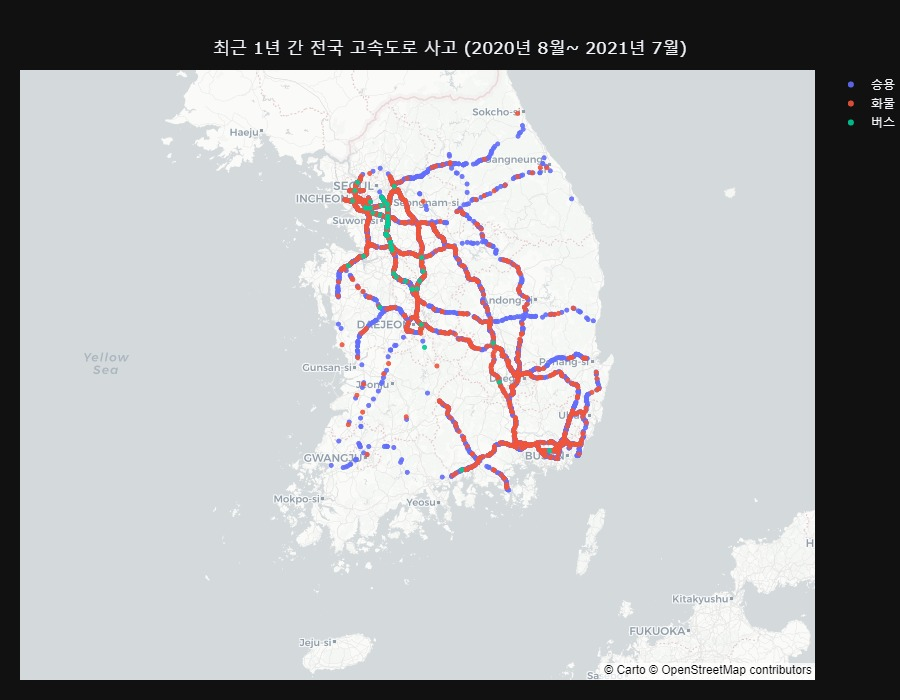

In [50]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')
# 시각화
title = '최근 1년 간 전국 고속도로 사고 (2020년 8월~ 2021년 7월)'
center = {'lat': 35.9, 'lon': workdata_df['c_경도'].median()}
fig = px.scatter_mapbox(workdata_df, lon='c_경도', lat='c_위도', color='c_차종', opacity=0.9,
                        color_continuous_scale='sunsetdark', title=title, center=center, zoom=6)
fig.update_layout(px_layout, mapbox_style="carto-positron", margin={"r":0,"t":70,"l":20,"b":20},
                  width=900, height=700, legend_title_text=None)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

#### 3.1.2 일평균 발생 사고 (월별)
> 일평균 사고는 **8월** (33.45건/일)에 가장 많았고, **1월** (25.68건/일)에 가장 적었습니다.


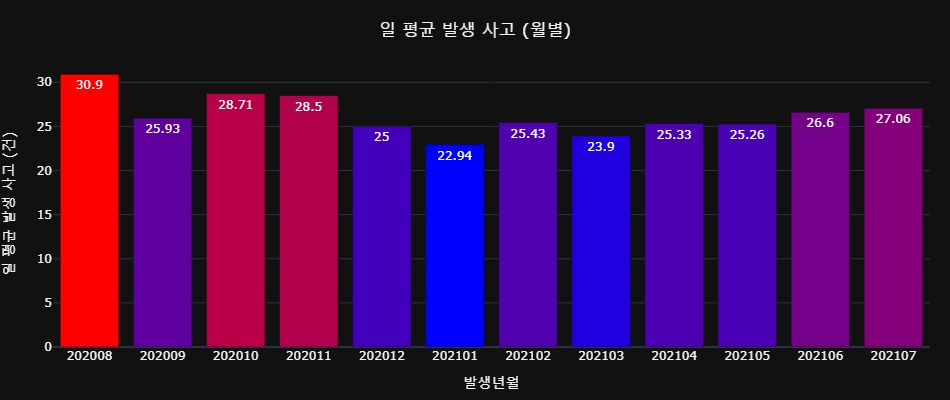

In [48]:
# 데이터 준비
workdata_df = t1_cd.get('accidents').copy()
workdata_df['발생년월'] = workdata_df['발생일자'].str[:6]
workdata_df = workdata_df.groupby('발생년월')[['발생년월']].count().rename(columns={'발생년월': '발생건수'}).reset_index()
workdata_df['총일수'] = pd.to_datetime(workdata_df['발생년월'], format='%Y%m').dt.days_in_month
workdata_df['일평균발생사고'] = round(workdata_df['발생건수'] / workdata_df['총일수'], 2)
# 시각화
fig = px.bar(workdata_df, x='발생년월', y='일평균발생사고', text='일평균발생사고', title='일 평균 발생 사고 (월별)',
             labels={'일평균발생사고': '일 평균 발생 사고 (건)'}, color='일평균발생사고', color_continuous_scale='bluered')
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

#### 3.1.3 1km 당 사고 빈도 (노선별)
> 1km당 사고 빈도는 **수도권제1순환선** (9.2건/km)이 가장 높았고, **고창담양선** (0.02건/km)이 가장 낮았습니다.


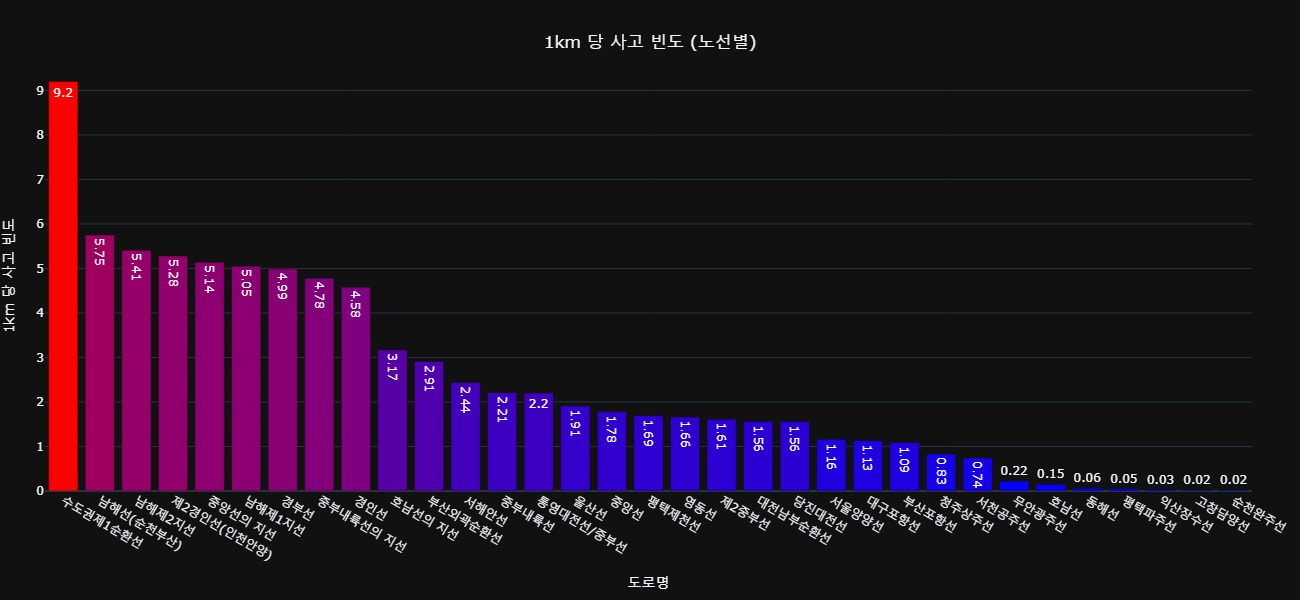

In [6]:
# 데이터 준비
workdata_df = t1_cd.get('accidents').copy()
workdata_df = workdata_df.groupby(['c_노선번호(도로중심선)', 'c_도로명'])[['발생일자']].count() \
              .rename(columns={'발생일자': '발생건수'}).reset_index()
workdata_2_sr = t1_cd.get('clor').groupby('노선번호')['이정'].count().divide(10).rename('총연장(km)')
workdata_df = workdata_df.merge(workdata_2_sr, left_on='c_노선번호(도로중심선)', right_on='노선번호')
workdata_df['1km 당 사고 빈도'] = round(workdata_df['발생건수'] / workdata_df['총연장(km)'], 2)
# 시각화
labels = {'c_도로명': '도로명'}
fig = px.bar(workdata_df, x='c_도로명', y='1km 당 사고 빈도', text='1km 당 사고 빈도', 
             title='1km 당 사고 빈도 (노선별)', labels=labels, color='1km 당 사고 빈도', color_continuous_scale='bluered')
fig.update_layout(px_layout, width=1300, height=600)
fig.update_xaxes(categoryorder='total descending')
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

#### 3.1.4 1km 구간 별 사고 빈도
> 1km당 발생 빈도가 가장 높은 구간은,
> - 모든 차종 : **경부선 (376.0 ~ 376.9km, 103건)**
> - 승용 차종 : **경부선 (376.0 ~ 376.9km, 98건)**
> - 화물 차종 : **남해선(순천부산) (127, 127.9km, 13건)**
>
> 이었습니다.
- 전국의 고속도를 1km 단위로 나눈 구간 별 사고 빈도 입니다.


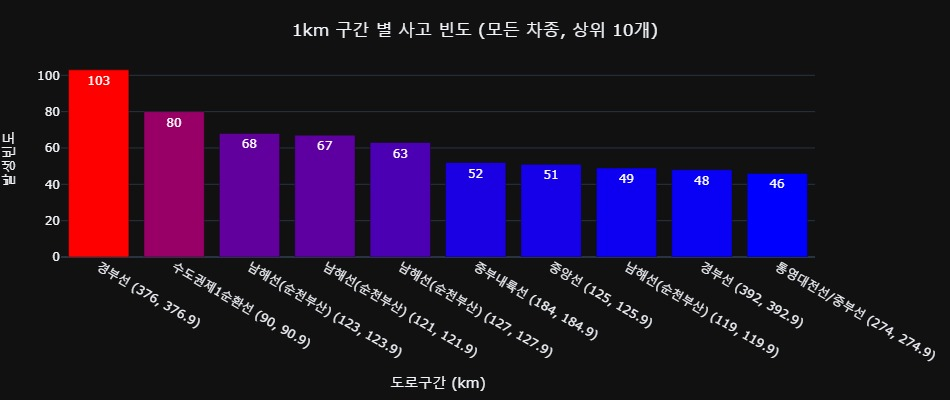


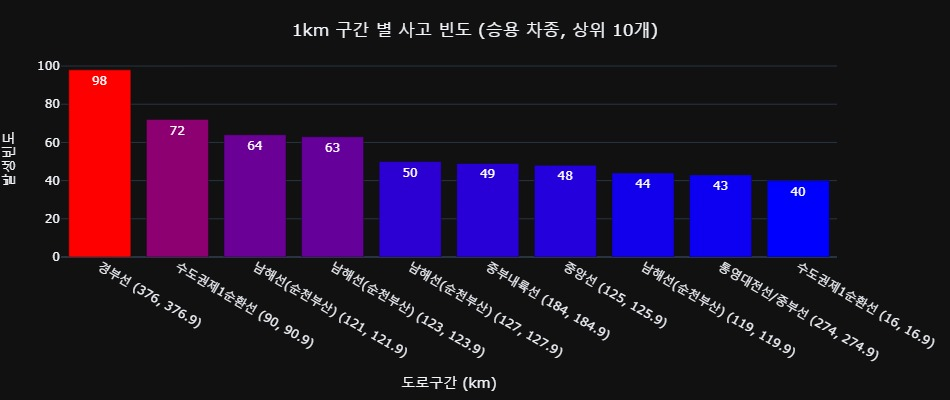


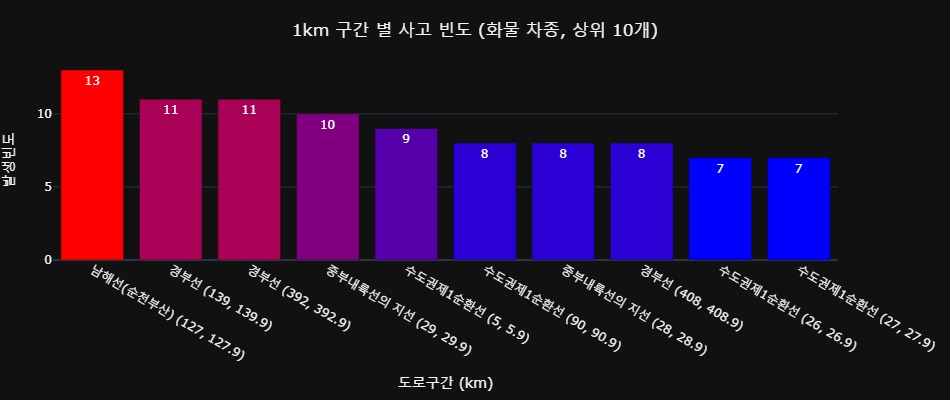


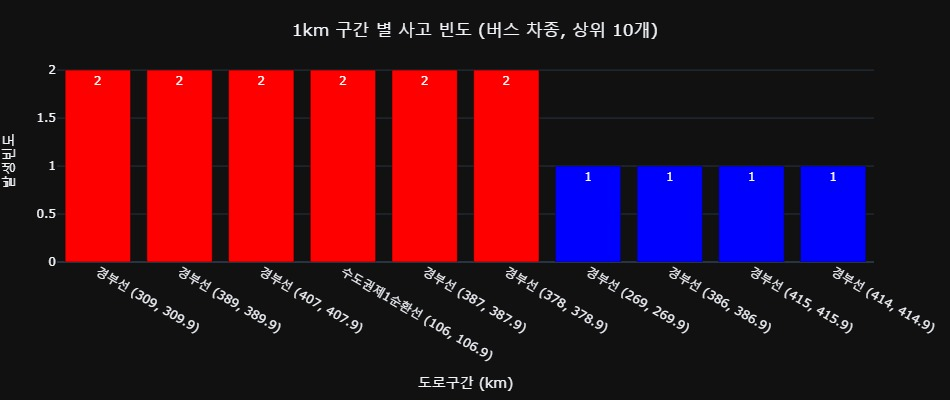

In [7]:
# 데이터 준비
workdata_df = t1_cd.get('accidents').copy()
columns = {'발생일자': '발생빈도'}
workdata_df = workdata_df.groupby(['c_차종', 'c_도로명','c_관찰구간'])[['발생일자']].count()  \
              .rename(columns=columns).sort_values('발생빈도', ascending=False).reset_index()
workdata_df['도로구간'] = workdata_df['c_도로명'] + ' (' + workdata_df['c_관찰구간'] + ')'
workdata_a_df = workdata_df.groupby(['c_도로명', 'c_관찰구간', '도로구간'])['발생빈도'].sum() \
                .sort_values(ascending=False).reset_index().head(10)
workdata_p_df = workdata_df[workdata_df['c_차종'] == '승용'].head(10)
workdata_c_df = workdata_df[workdata_df['c_차종'] == '화물'].head(10)
workdata_b_df = workdata_df[workdata_df['c_차종'] == '버스'].head(10)
# 시각화
title = '1km 구간 별 사고 빈도 (모든 차종, 상위 10개)'
labels = {'도로구간': '도로구간 (km)'}
fig_a = px.bar(workdata_a_df, x='도로구간', y='발생빈도', text='발생빈도', title=title, labels=labels, color='발생빈도')
fig_a.update_layout(px_layout, height=400)
title = '1km 구간 별 사고 빈도 (승용 차종, 상위 10개)'
fig_p = px.bar(workdata_p_df, x='도로구간', y='발생빈도', text='발생빈도', title=title, labels=labels, color='발생빈도')
fig_p.update_layout(px_layout, height=400)
title = '1km 구간 별 사고 빈도 (화물 차종, 상위 10개)'
fig_c = px.bar(workdata_c_df, x='도로구간', y='발생빈도', text='발생빈도', title=title, labels=labels, color='발생빈도')
fig_c.update_layout(px_layout, height=400)
title = '1km 구간 별 사고 빈도 (버스 차종, 상위 10개)'
fig_b = px.bar(workdata_b_df, x='도로구간', y='발생빈도', text='발생빈도', title=title, labels=labels, color='발생빈도')
fig_b.update_layout(px_layout, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_a.to_image(format='jpg')))
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_p.to_image(format='jpg')))
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_c.to_image(format='jpg')))
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_b.to_image(format='jpg')))

#### 3.1.5 1km 구간 별 주중·주말 사고율 (각 5개 구간)
> 1km 구간 별 주중·주말 사고율 상위 각 5개 구간은,
> - 주중 사고율 상위 5 구간 : 경부선 (397, 397.9) 100%, 경부선 (385, 385.9) 100%, 영동선 (21, 21.9) 100%, 수도권제1순환선 (20, 20.9) 100%, 서해안선 (335, 335.9) 100% 등
> - 주말 사고율 상위 5 구간 : 경부선 (315, 315.9) 90%, 부산외곽순환선 (48, 48.9) 88.89%, 경부선 (320, 320.9) 88.89%, 경부선 (321, 321.9) 87.5%, 경부선 (331, 331.9) 87.5%
>
> 이었습니다.

- 전국의 고속도를 1km 단위로 나눈 구간 별 주중·주말 사고율 입니다.

,도로구간,주중사고비율,주말사고비율,발생빈도
0,"경부선 (397, 397.9)",100.0,0.0,14
1,"경부선 (385, 385.9)",100.0,0.0,13
2,"영동선 (21, 21.9)",100.0,0.0,13
3,"수도권제1순환선 (20, 20.9)",100.0,0.0,12
4,"서해안선 (335, 335.9)",100.0,0.0,10

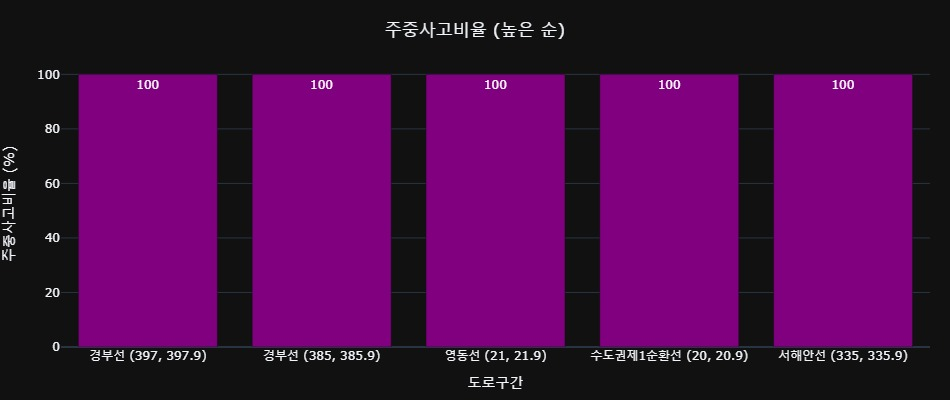

,도로구간,주중사고비율,주말사고비율,발생빈도
0,"경부선 (315, 315.9)",10.00,90.00,1
1,"경부선 (320, 320.9)",11.11,88.89,1
2,"부산외곽순환선 (48, 48.9)",11.11,88.89,1
3,"경부선 (321, 321.9)",12.50,87.50,1
4,"경부선 (331, 331.9)",12.50,87.50,1

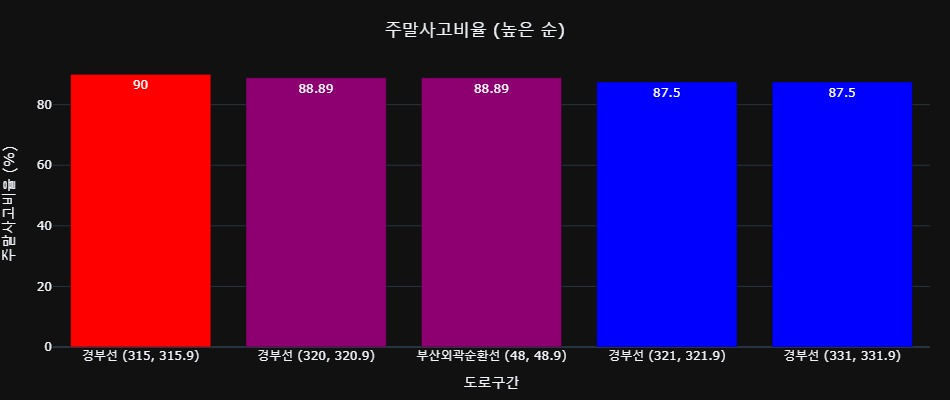

In [8]:
# 데이터 준비
workdata_df = t1_cd.get('accidents').copy()
workdata_df = workdata_df.groupby(['c_도로명', 'c_관찰구간', 'c_주중주말'])[['발생일자']].count() \
              .rename(columns={'발생일자': '발생빈도'}).reset_index()
workdata_df['도로구간'] = workdata_df['c_도로명'] + ' (' + workdata_df['c_관찰구간'] + ')'
workdata_1_sr = workdata_df.groupby(['도로구간'])['발생빈도'].transform('sum')
workdata_df['주중주말사고비율'] = round(workdata_df['발생빈도'] / workdata_1_sr * 100, 2)
workdata_df = workdata_df[workdata_df['c_주중주말'] == '주중'].drop('c_주중주말', axis=1) \
              .rename(columns={'주중주말사고비율': '주중사고비율'}).reset_index(drop=True)
workdata_df['주말사고비율'] = 100.0 - workdata_df['주중사고비율']
# 시각화
# 주중사고비율 상위 5개 구간
workdata_2_df = workdata_df[['도로구간', '주중사고비율', '주말사고비율', '발생빈도']] \
                .sort_values(['주중사고비율', '발생빈도'], ascending=False).reset_index(drop=True)[:5]
fig = px.bar(workdata_2_df, x='도로구간', y='주중사고비율', text='주중사고비율', title='주중사고비율 (높은 순)',
             labels={'주중사고비율': '주중사고비율 (%)'}, color='주중사고비율')
fig.update_layout(px_layout)
CustomUtils.display_htmls(workdata_2_df.to_html(), CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))
# 주말사고비율 상위 5개 구간
workdata_2_df = workdata_df[['도로구간', '주중사고비율', '주말사고비율', '발생빈도']] \
                .sort_values(['주말사고비율', '발생빈도'], ascending=False).reset_index(drop=True)[:5]
fig = px.bar(workdata_2_df, x='도로구간', y='주말사고비율', text='주말사고비율', title='주말사고비율 (높은 순)',
             labels={'주말사고비율': '주말사고비율 (%)'}, color='주말사고비율')
fig.update_layout(px_layout)
CustomUtils.display_htmls(workdata_2_df.to_html(), CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

### 3.2 사고 다발 구간
> 사고 빈도 상위 10개 구간을 분석하였습니다.

#### 3.2.1 경부선 (376 ~ 376.9 km) 구간
> **전체 사고빈도 1위 (103건), 승용 사고빈도 1위 (98건), 화물 사고빈도 38위 (4건), 버스 사고빈도 7위 (1건).**<br>
> `지상도로` `직선`


##### 3.2.1.1 구간 개요


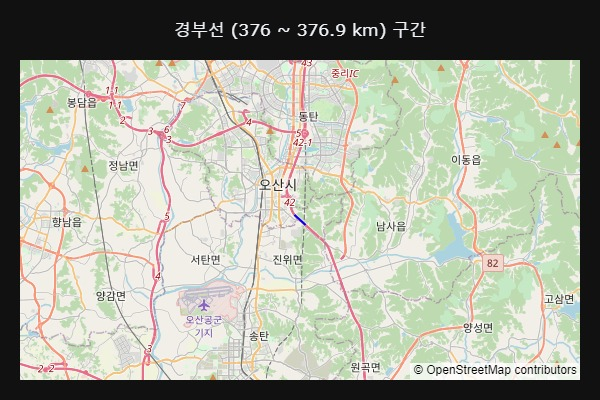
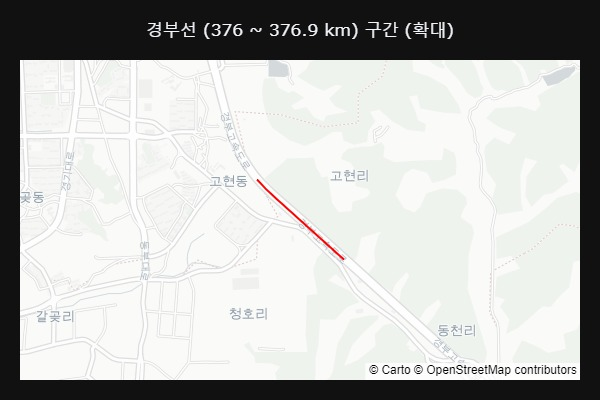

이미지 출처 : 네이버 지도 - 거리뷰

In [9]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='경부선')
                                & (376 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 376.9)]
# 시각화
title = '경부선 (376 ~ 376.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '경부선 (376 ~ 376.9 km) 구간 (확대)'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                       color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))
img_url = "https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%EA%B2%BD%EB%B6%80%EC%84%A0_376_377.jpg"
CustomUtils.display_htmls(f'<img src="{img_url}">')
CustomUtils.display_htmls('<p><sub>이미지 출처 : 네이버 지도 - 거리뷰</sub></p>')

##### 3.2.1.2 주중 주말 사고 빈도


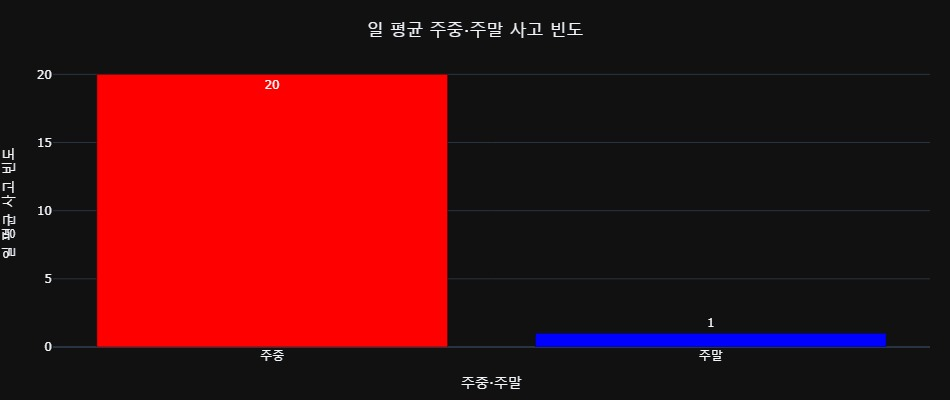

In [10]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '경부선') & (t1_cd.get('accidents')['c_관찰구간'] == '376, 376.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='일 평균 주중·주말 사고 빈도',
             color=workdata_sr.values, labels={'index': '주중·주말', 'y': '일 평균 사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.1.3 원인 분석 및 개선안

원인 분석

- 경부선 376.4km지점에서 버스 전용차로가 시작(상행선)되고, 종료(하행선)됩니다.
- 평일 버스전용차로를 이용하다가 종료된 버스가 통상 차로로 진입하면서 사고의 유발과 정체가 발생합니다.
- 오산IC와 지리적으로 가까워 IC로 붐비는 곳에 버스 전용차로 문제까지 겹치니 문제가 많이 발생합니다.

개선안

- 버스 전용차로 시작점을 오산나들목과 떨어져 있고 선형이 직선인 도로이정기준 371.9km 로 이전합니다.
- 버스 전용차로 시작 예정 안내판을 강조합니다.


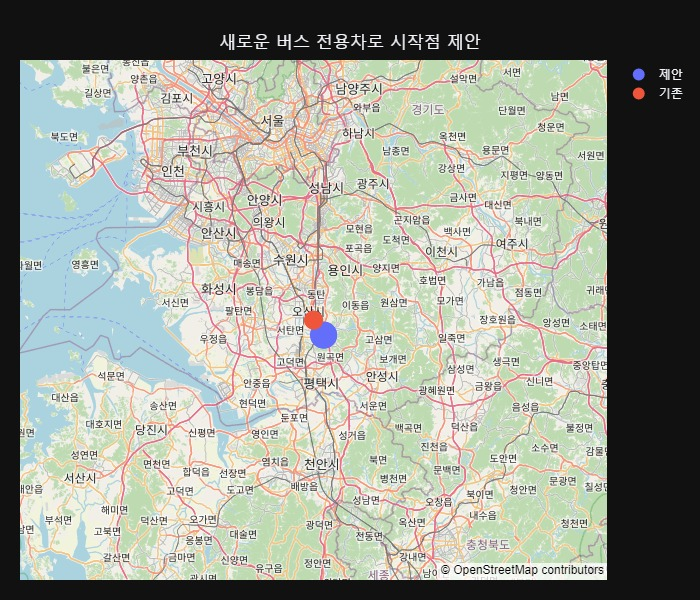
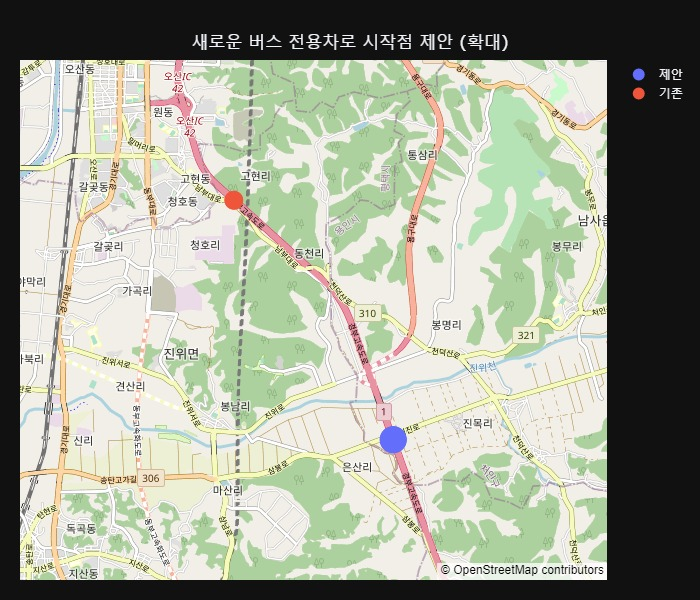

In [11]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명'] == '경부선') & (t1_cd.get('clor')['이정'].isin([376.4, 371.9]))]
# 시각화
title = '새로운 버스 전용차로 시작점 제안'
fig_1 = px.scatter_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=8, size=[30, 15], color=['제안', '기존'],
                                   opacity=1.0)
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=700, height=600, showlegend=True, legend_title_text=None)
title = '새로운 버스 전용차로 시작점 제안 (확대)'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_2 = px.scatter_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=12, size=[30, 15], color=['제안', '기존'],
                                   opacity=1.0)
fig_2.update_layout(px_layout, mapbox_style='open-street-map', width=700, height=600, showlegend=True, legend_title_text=None)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

#### 3.2.2 수도권제1순환선 (90 ~ 90.9 km) 구간
> 전체 사고빈도 2위 (80건), 승용 사고빈도 2위 (72건), 화물 사고빈도 8위 (6건), 버스 사고빈도 없음.<br>
> `고가도로` `곡선`

##### 3.2.2.1 구간 개요


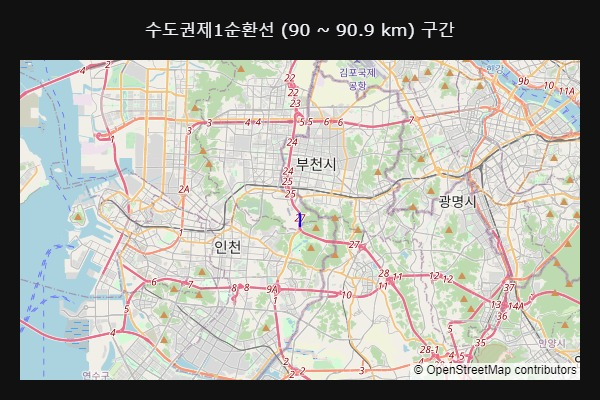
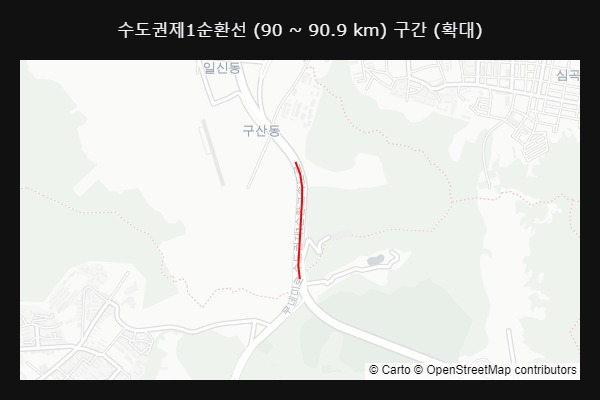

이미지 출처 : 네이버 지도 - 거리뷰

In [12]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='수도권제1순환선')
                                & (90 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 90.9)]
# 시각화
title = '수도권제1순환선 (90 ~ 90.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '수도권제1순환선 (90 ~ 90.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))
img_url = "https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%EC%88%98%EB%8F%84%EA%B6%8C%EC%A0%9C1%EC%88%9C%ED%99%98%EC%84%A0_90_91.jpg"
CustomUtils.display_htmls(f'<img src="{img_url}">')
CustomUtils.display_htmls('<p><sub>이미지 출처 : 네이버 지도 - 거리뷰</sub></p>')

##### 3.2.2.2 차종 별 사고 빈도


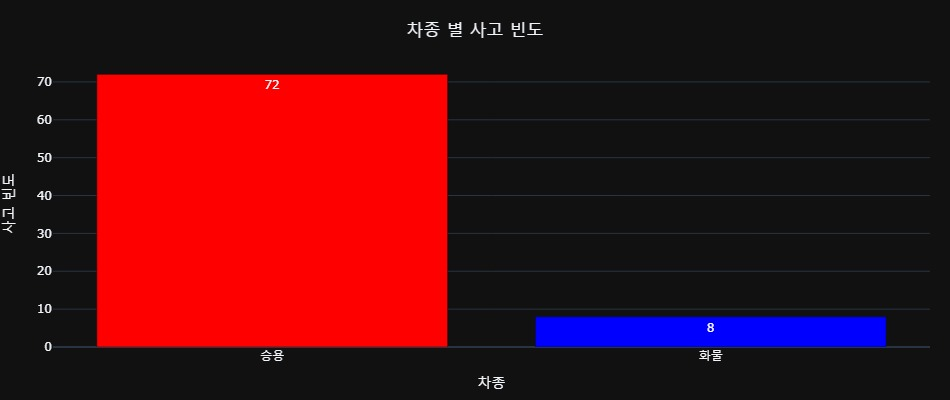

In [13]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '수도권제1순환선') & (t1_cd.get('accidents')['c_관찰구간'] == '90, 90.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.2.3 주중·주말 사고 빈도


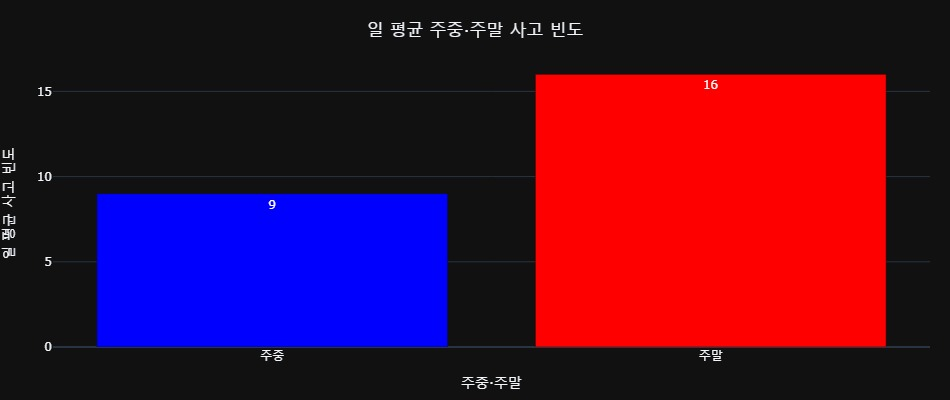

In [14]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '수도권제1순환선') & (t1_cd.get('accidents')['c_관찰구간'] == '90, 90.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='일 평균 주중·주말 사고 빈도',
             color=workdata_sr.values, labels={'index': '주중·주말', 'y': '일 평균 사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.2.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 해당 구간은 합류지점으로 "무네미로"를 통해 많은 차량이 합류되고 있습니다.
- 해당 합류 구간에서 합류 차량 중 일부가 동시에 여러 차선을 변경합니다.
- 합류 차선이 2개 차선으로 합류되어 혼잡이 발생합니다.

개선안
- 본선 우측 1개 차선을 합류 우선 차선으로 배정하여 원활한 흐름을 유도합니다.
- 혼잡도와 통행 시간을 안내해주는 가변정보표지판(VMS)을 설치하여 교통량 분산을 유도합니다.

#### 3.2.3 남해선(순천부산) (123 ~ 123.9 km) 구간
> 전체 사고빈도 3위 (68건), 승용 사고빈도 4위 (63건), 화물 사고빈도 20위 (5건), 버스 사고빈도 없음.<br>
> `터널` `직선`


##### 3.2.3.1 구간 개요


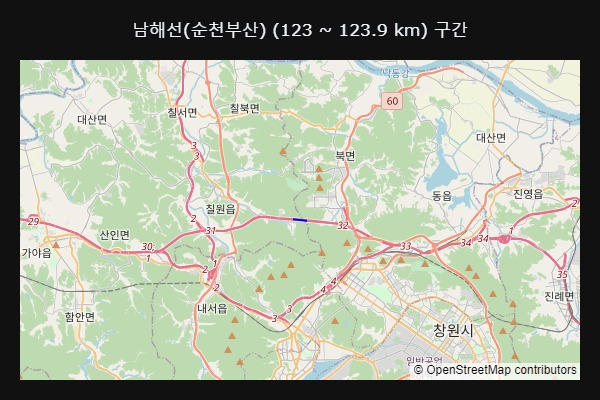
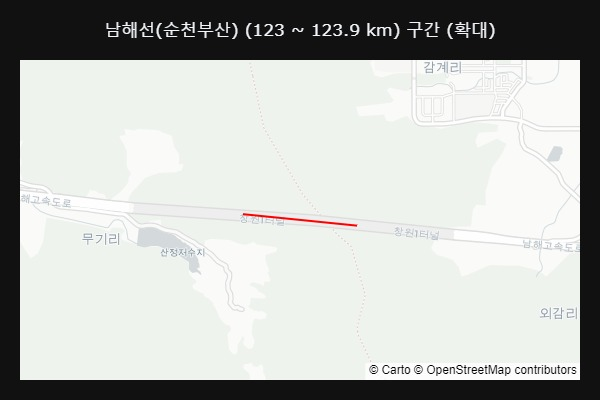

이미지 출처 : 네이버 지도 - 거리뷰

In [15]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='남해선(순천부산)')
                                & (123 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 123.9)]
# 시각화
title = '남해선(순천부산) (123 ~ 123.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '남해선(순천부산) (123 ~ 123.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))
img_url = "https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%EB%82%A8%ED%95%B4%EC%84%A0_%EC%88%9C%EC%B2%9C%EB%B6%80%EC%82%B0_123_124.png"
CustomUtils.display_htmls(f'<img src="{img_url}">')
CustomUtils.display_htmls('<p><sub>이미지 출처 : 네이버 지도 - 거리뷰</sub></p>')

##### 3.2.3.2 차종 별 사고 빈도


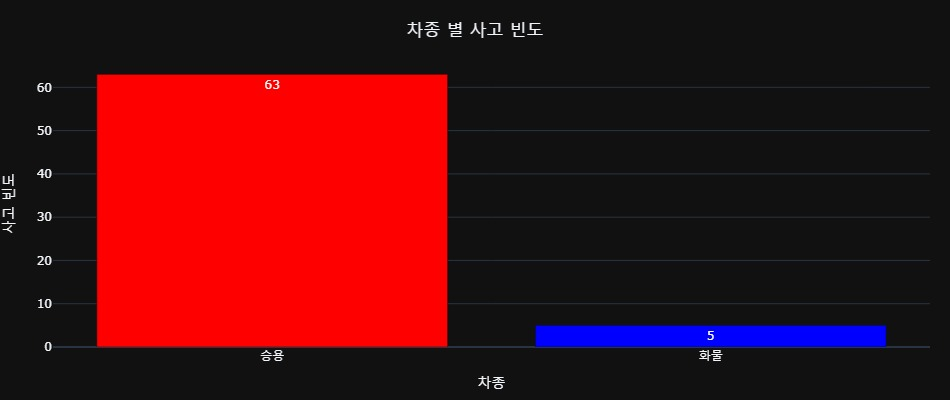

In [16]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '123, 123.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.3.3 주중·주말 사고 빈도


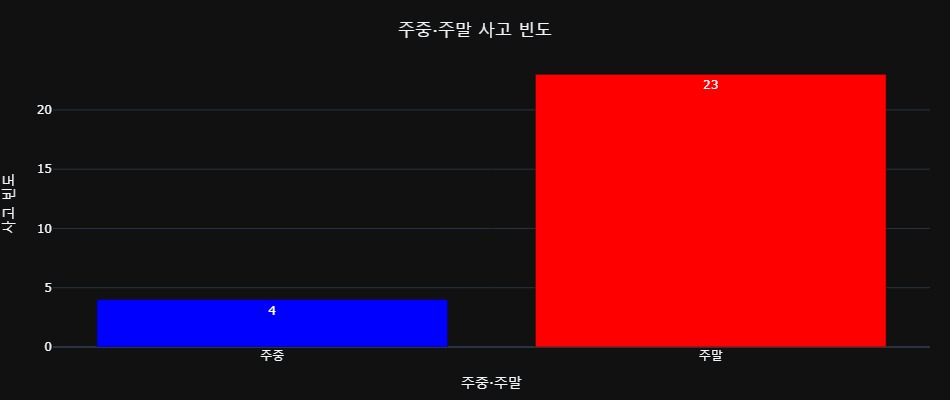

In [17]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '123, 123.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.3.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 터널 구간 : 창원 제1터널입니다.
- 차선 감소 : 창원분기점 전후로 4차선에서 2차선으로 차선이 줄어들어 차량 정체가 발생합니다.

개선안
- 우회로 유도 : 우회로인 남해 제1지선 이용을 유도합니다. 특히 남해 제1지선은 2018년부터 갓길 차로제를 활용해 교통량 증가에 유연하게 대처할 수 있습니다.<sup>[(1)](#footnote_3233a)</sup>
- 우회로 유도 : 도공, 남해선 정체시 남해제1지선 이용 추천<sup>[(2)](#footnote_3233b)</sup>
- 우회로 신설 : 북쪽으로 우회로를 신설합니다.
- 도로 용량 확대 : 도로 폭을 확장합니다.
- 해당 구간에 강력한 주의문구를 추가합니다.

<sub><a name='footnote_3233a'>(1)</a> 한국도로공사 갓길차로제 운영 현황 - https://www.data.go.kr/data/15001283/fileData.do</sub><br>
<sub><a name='footnote_3233b'>(2)</a> [기관소식] 도공, 남해선 정체시 남해제1지선 이용 추천 - https://www.kukinews.com/newsView/kuk202106050029</sub>

#### 3.2.4 남해선(순천부산) (121 ~ 121.9 km) 구간
> 전체 사고빈도 4위 (67건), 승용 사고빈도 3위 (64건), 화물 사고빈도 70위 (3건), 버스 사고빈도 없음.<br>
> `고가도로` `직선`


##### 3.2.4.1 구간 개요


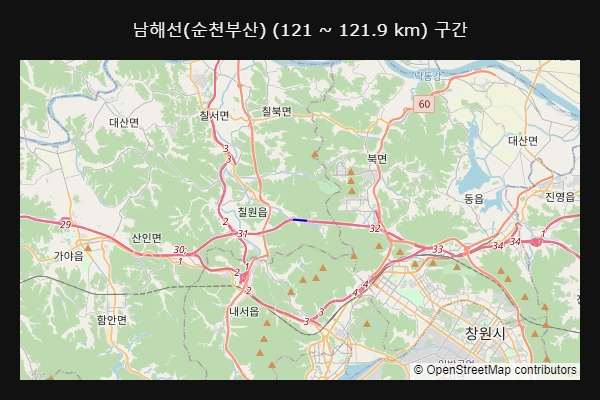
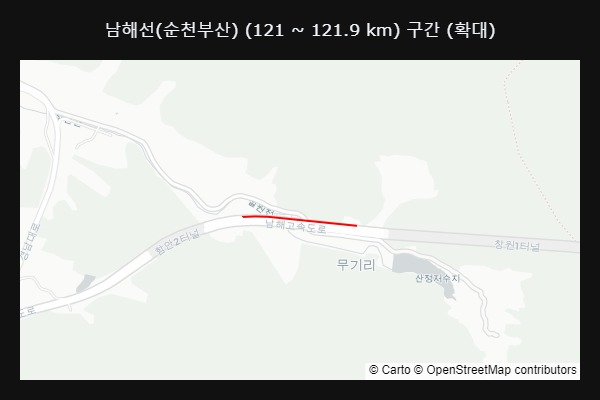

In [18]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='남해선(순천부산)')
                                & (121 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 121.9)]
# 시각화
title = '남해선(순천부산) (121 ~ 121.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '남해선(순천부산) (121 ~ 121.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.4.2 차종 별 사고 빈도


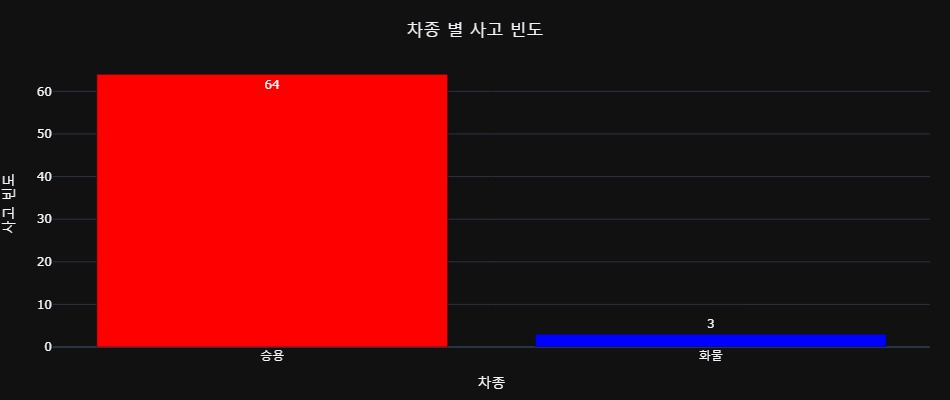

In [19]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '121, 121.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.4.3 주중·주말 사고 빈도


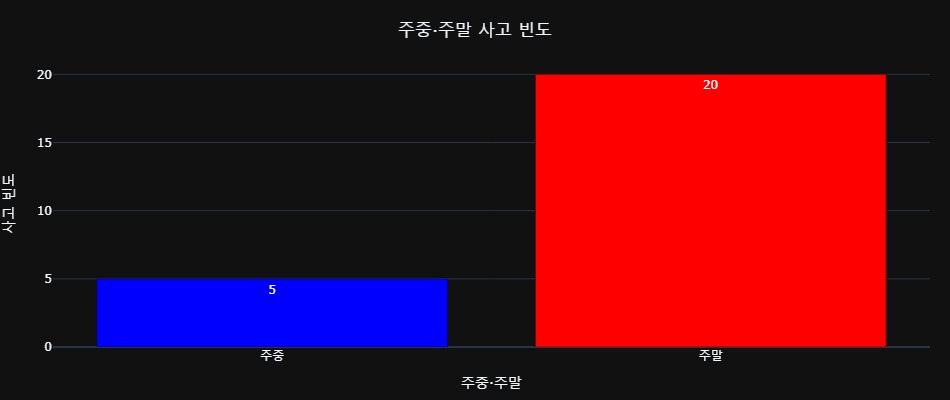

In [20]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '121, 121.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.4.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 창원1터널과 함안2터널을 연결하는 교량이 혼재된 구간입니다.
- 터널과 터널의 연결 구간 : 함안2터널을 나오자 마자 이어진 급격한 커브와 창원 제1터널의 정체가 맞물리는 구간입니다.<br>
![함안2터널_출입지점](https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%ED%95%A8%EC%95%88%EC%A0%9C2%ED%84%B0%EB%84%90_%EC%B6%9C%EC%9E%85%EC%A7%80%EC%A0%90.png)
- 커브 : 해당 구간의 급격한 커브로 인해 앞쪽의 시야가 확보되지 않습니다.<br>
![함안2터널_곡선](https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%ED%95%A8%EC%95%88%EC%A0%9C2%ED%84%B0%EB%84%90+%EC%BB%A4%EB%B8%8C.jpg)
- 시야 장애물: 커브 구간에서 시야를 방해하는 석축과 장애물이 있습니다.

개선안
- VMS: VMS를 설치하여 함안2터널을 나오자 마자 커브 이후의 구간에 대한 정보를 전달합니다. 예) 정체, 원활 등
- 해당 구간에 강력한 주의 문구를 설치합니다.
- 시야를 방해하는 석축과 장애물을 제거합니다.

#### 3.2.5 남해선(순천부산) (127 ~ 127.9 km) 구간
> 전체 사고빈도 5위 (63건), 승용 사고빈도 5위 (50건), 화물 사고빈도 1위 (13건), 버스 사고빈도 없음.<br>
> `지상도로` `직선`


##### 3.2.5.1 구간 개요


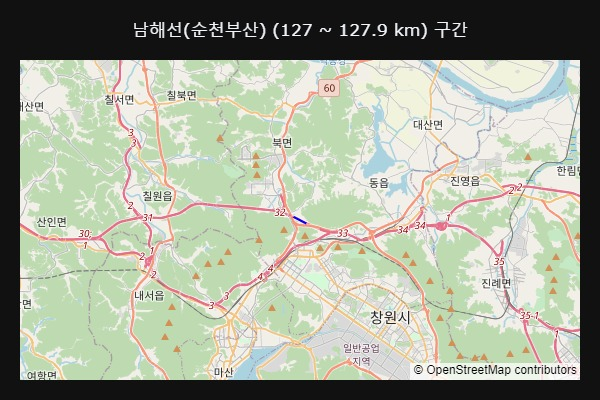
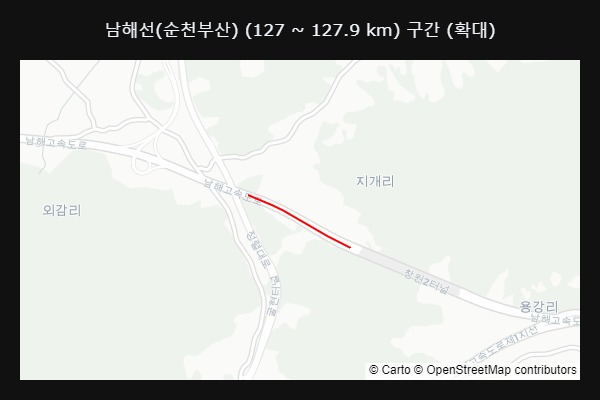

In [21]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='남해선(순천부산)')
                                & (127 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 127.9)]
# 시각화
title = '남해선(순천부산) (127 ~ 127.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '남해선(순천부산) (127 ~ 127.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.5.2 차종 별 사고 빈도


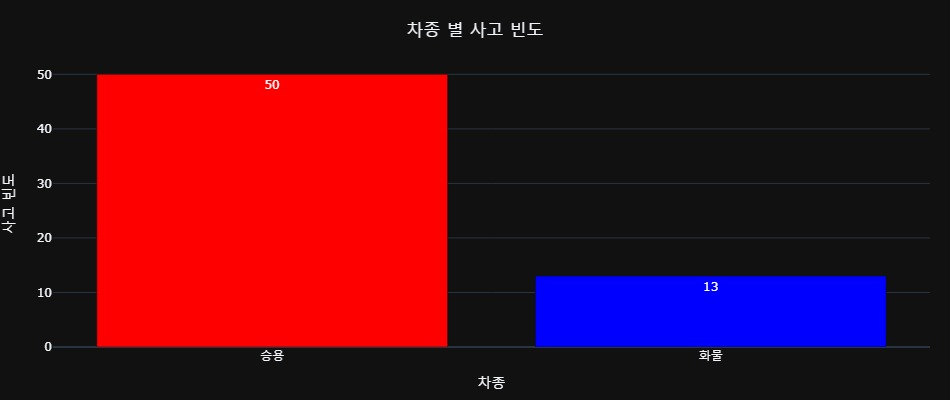

In [22]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '127, 127.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.5.3 주중·주말 사고 빈도


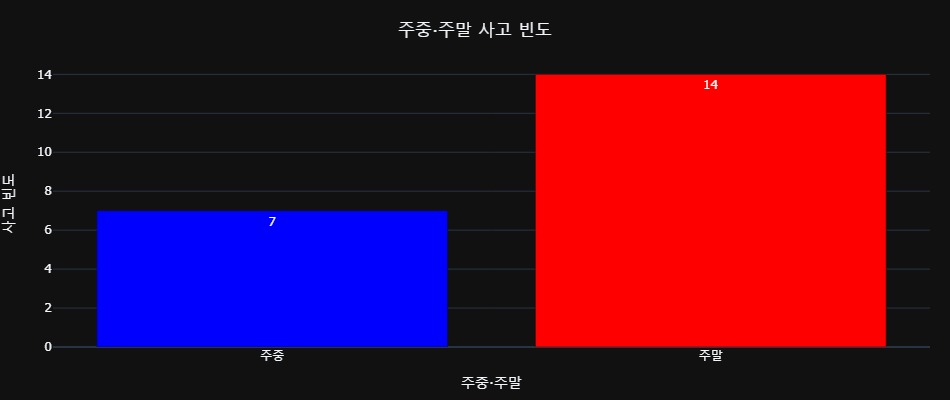

In [23]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '127, 127.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.5.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 터널 주변 : 인근에 창원2터널이 있습니다.

개선안
- 우회로 유도 : 우회로인 남해 제1지선 이용을 유도합니다. 특히 남해 제1지선은 2018년부터 갓길 차로제를 활용해 교통량 증가에 유연하게 대처할 수 있습니다.<sup>[(1)](#footnote_3233a)</sup>
- 우회로 유도 : 도공, 남해선 정체시 남해제1지선 이용 추천<sup>[(2)](#footnote_3233b)</sup>
- 우회로 신설 : 북쪽으로 우회로를 신설합니다.
- 도로 용량 확대 : 도로 폭을 확장합니다.
- 해당 구간에 강력한 주의문구를 추가합니다.

<sub><a name='footnote_3233a'>(1)</a> 한국도로공사 갓길차로제 운영 현황 - https://www.data.go.kr/data/15001283/fileData.do</sub><br>
<sub><a name='footnote_3233b'>(2)</a> [기관소식] 도공, 남해선 정체시 남해제1지선 이용 추천 - https://www.kukinews.com/newsView/kuk202106050029</sub>

#### 3.2.6 중부내륙선 (184 ~ 184.9 km) 구간
> 전체 사고빈도 6위 (52건), 승용 사고빈도 6위 (49건), 화물 사고빈도 129위 (3건), 버스 사고빈도 없음.<br>
> `터널` `직선`


##### 3.2.6.1 구간 개요


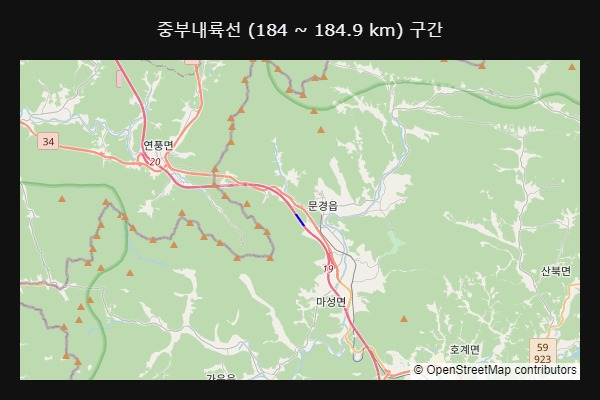
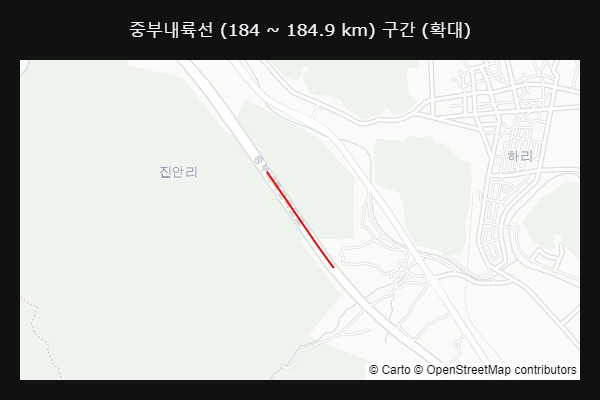

In [24]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='중부내륙선')
                                & (184 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 184.9)]
# 시각화
title = '중부내륙선 (184 ~ 184.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '중부내륙선 (184 ~ 184.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.6.2 차종 별 사고 빈도


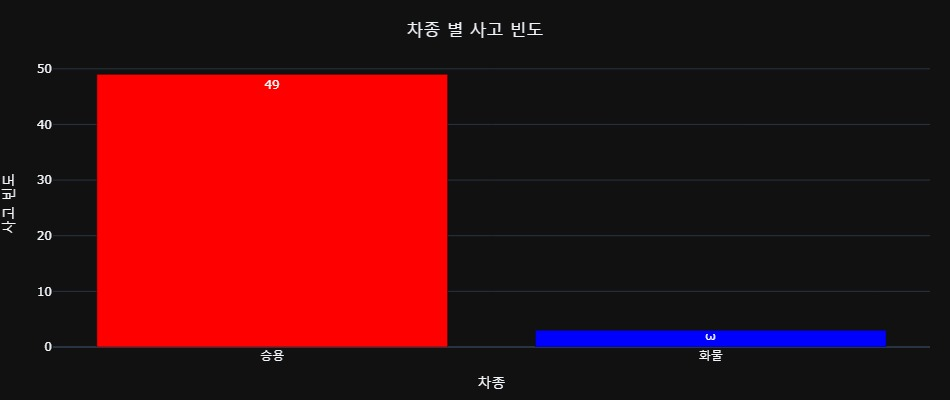

In [25]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '중부내륙선') & (t1_cd.get('accidents')['c_관찰구간'] == '184, 184.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.6.3 주중·주말 사고 빈도


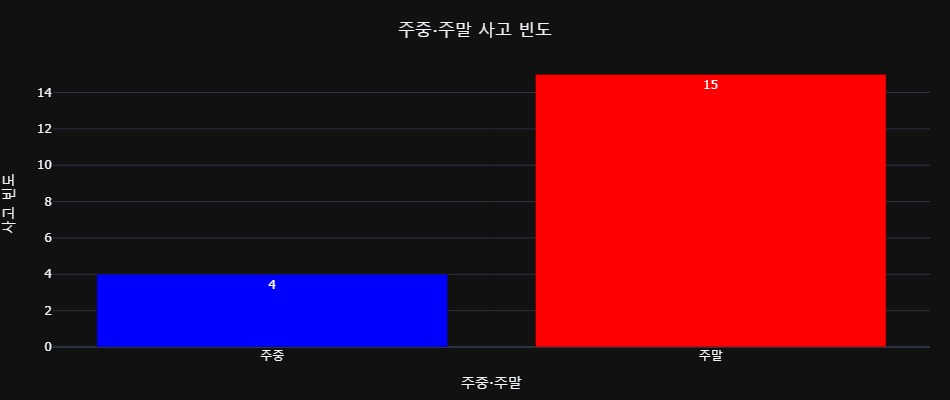

In [26]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '중부내륙선') & (t1_cd.get('accidents')['c_관찰구간'] == '184, 184.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.6.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 터널 구간 : 문경2터널 구간입니다.


#### 3.2.7 중앙선 (125 ~ 125.9 km) 구간
> 전체 사고빈도 7위 (51건), 승용 사고빈도 7위 (48건), 화물 사고빈도 123위 (3건), 버스 사고빈도 없음.<br>
> `터널` `직선`


##### 3.2.7.1 구간 개요


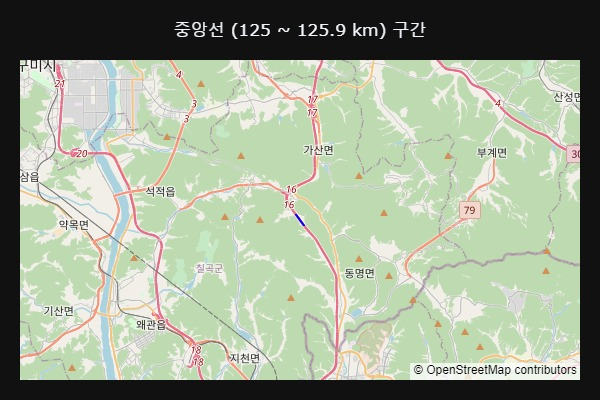
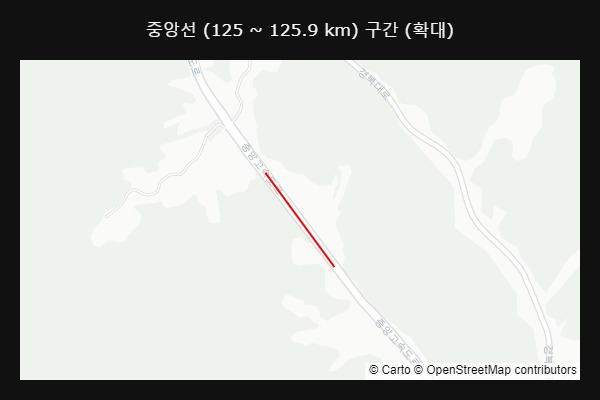

In [27]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='중앙선')
                                & (125 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 125.9)]
# 시각화
title = '중앙선 (125 ~ 125.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '중앙선 (125 ~ 125.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.7.2 차종 별 사고 빈도


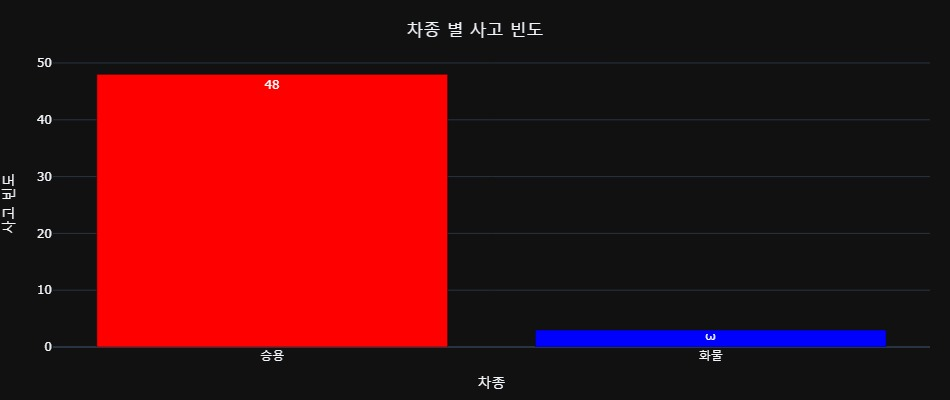

In [28]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '중앙선') & (t1_cd.get('accidents')['c_관찰구간'] == '125, 125.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.7.3 주중·주말 사고 빈도


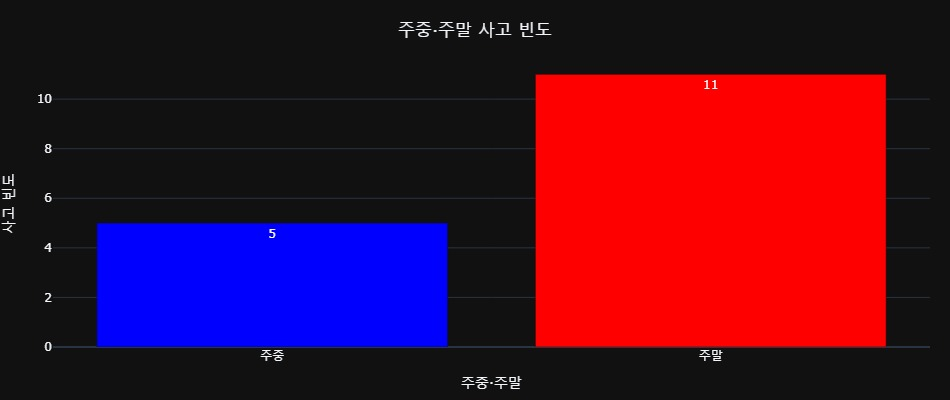

In [29]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '중앙선') & (t1_cd.get('accidents')['c_관찰구간'] == '125, 125.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.7.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 터널 구간 : 다부터널 구간입니다.


#### 3.2.8 남해선(순천부산) (119 ~ 119.9 km) 구간
> 전체 사고빈도 8위 (49건), 승용 사고빈도 8위 (44건), 화물 사고빈도 26위 (5건), 버스 사고빈도 없음.<br>
> `지상` `직선`


##### 3.2.8.1 구간 개요


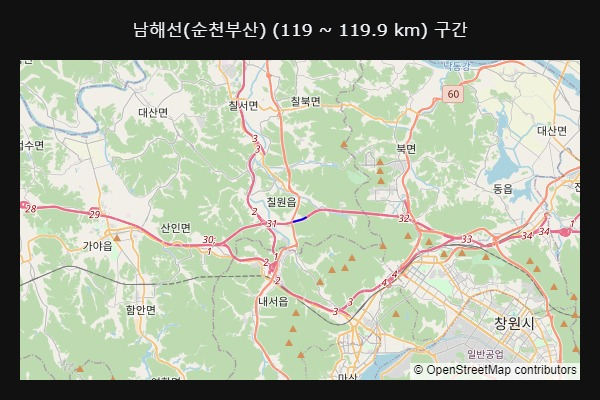
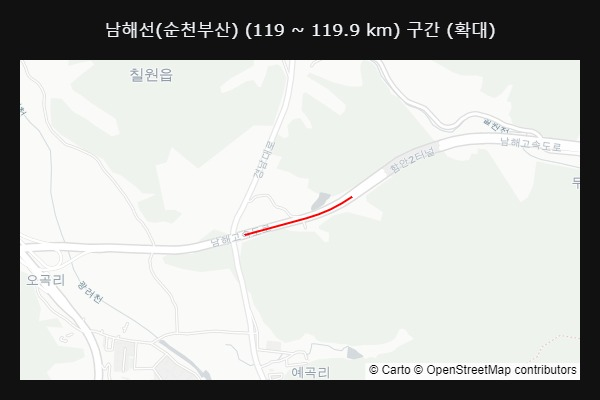

In [30]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='남해선(순천부산)')
                                & (119 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 119.9)]
# 시각화
title = '남해선(순천부산) (119 ~ 119.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '남해선(순천부산) (119 ~ 119.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.8.2 차종 별 사고 빈도


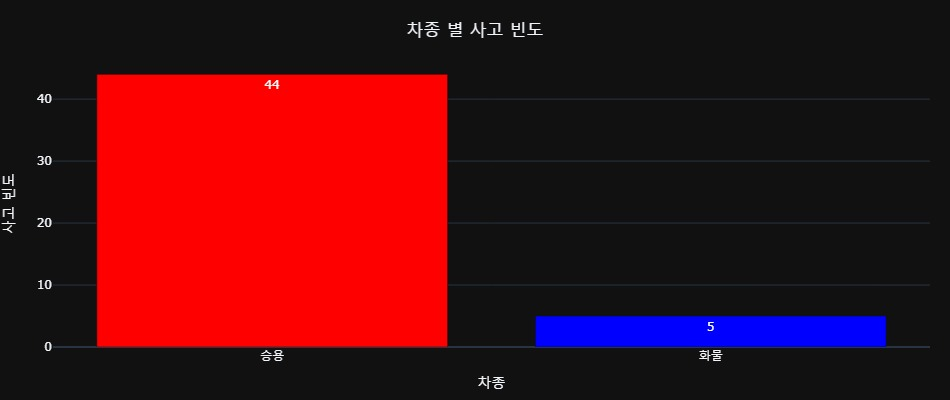

In [31]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '119, 119.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.8.3 주중·주말 사고 빈도


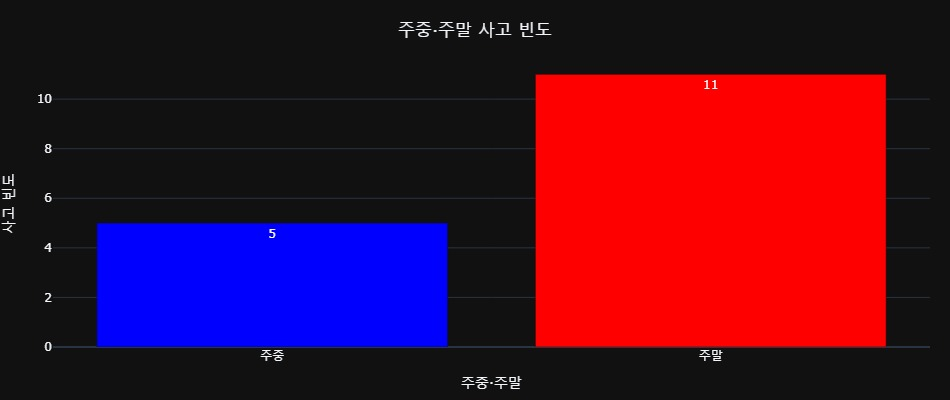

In [32]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '남해선(순천부산)') & (t1_cd.get('accidents')['c_관찰구간'] == '119, 119.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.8.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 터널 주변 : 인근에 함안2터널이 있습니다.


#### 3.2.9 경부선 (392 ~ 392.9 km) 구간
> 전체 사고빈도 9위 (48건), 승용 사고빈도 14위 (36건), 화물 사고빈도 2위 (11건), 버스 사고빈도 46위 (1건).<br>
> `지상` `직선`

##### 3.2.9.1 구간 개요


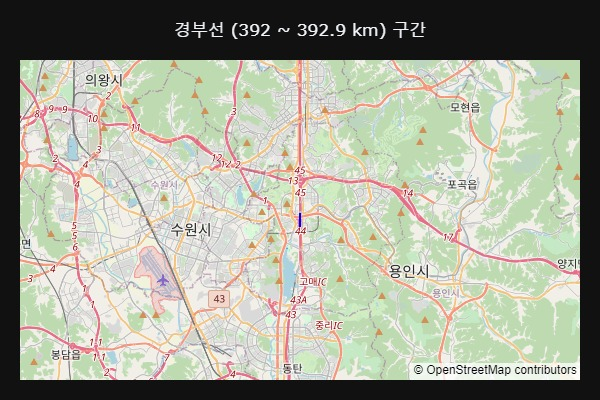
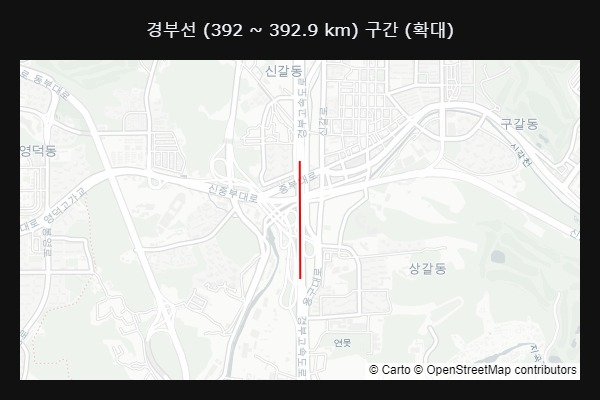

In [33]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='경부선')
                                & (392 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 392.9)]
# 시각화
title = '경부선 (392 ~ 392.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '경부선 (392 ~ 392.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.9.2 차종 별 사고 빈도


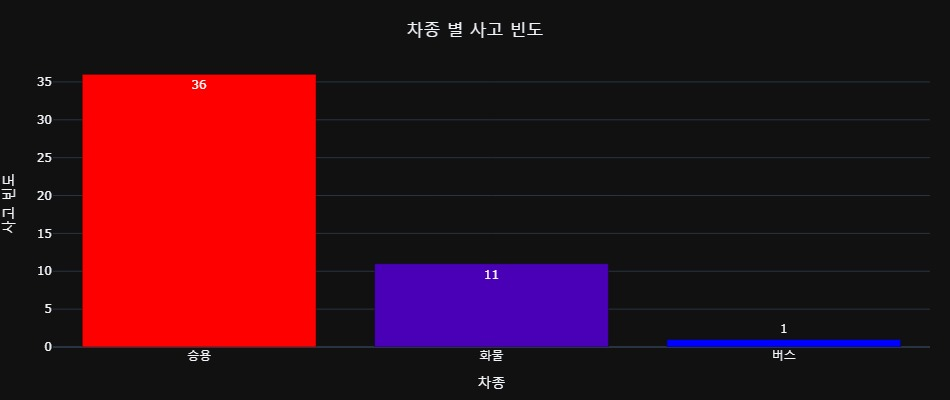

In [34]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '경부선') & (t1_cd.get('accidents')['c_관찰구간'] == '392, 392.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.9.3 주중·주말 사고 빈도


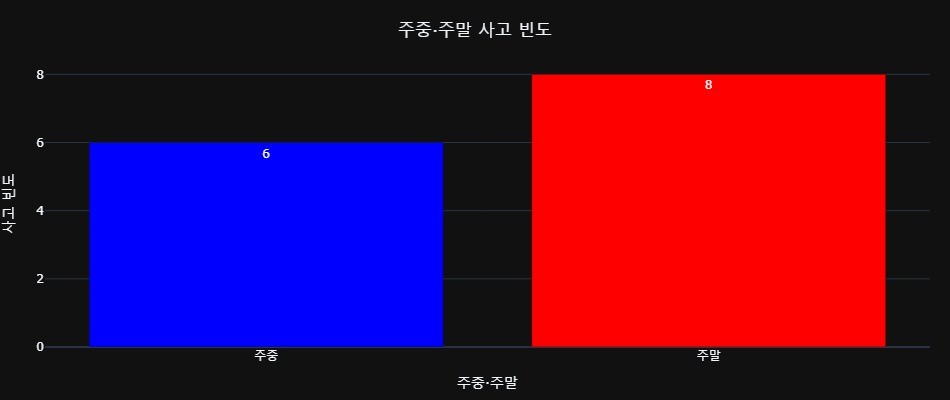

In [35]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '경부선') & (t1_cd.get('accidents')['c_관찰구간'] == '392, 392.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.9.4 원인 분석 및 개선안

현상 요약
- 승용의 사고 빈도가 높고 주중·주말의 사고 빈도가 비슷한 구간입니다.

원인 분석
- 복잡한 노선 구조

개선안
- 노선 구조를 정렬합니다.

#### 3.2.10 통영대전선/중부선 (274 ~ 274.9 km) 구간
> 전체 사고빈도 10위 (46건), 승용 사고빈도 9위 (43건), 화물 사고빈도 118위 (3건), 버스 사고빈도 없음 .<br>
> `교량` `곡선`

##### 3.2.10.1 구간 개요


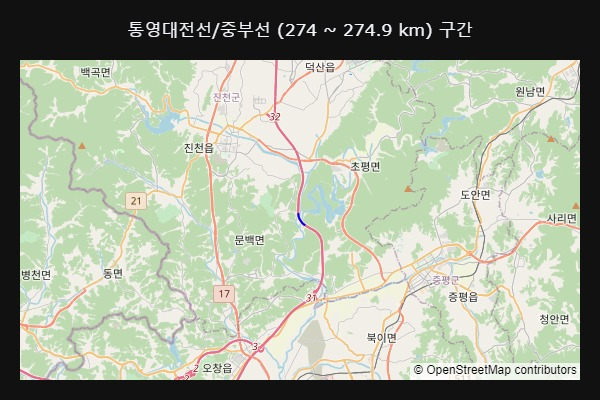
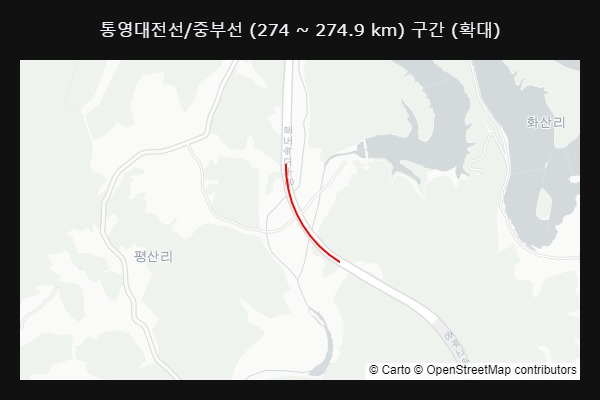

In [36]:
# 데이터 준비
workdata_df = t1_cd.get('clor')[(t1_cd.get('clor')['도로명']=='통영대전선/중부선')
                                & (274 <= t1_cd.get('clor')['이정'])
                                & (t1_cd.get('clor')['이정'] <= 274.9)]
# 시각화
title = '통영대전선/중부선 (274 ~ 274.9 km) 구간'
center = {'lat': workdata_df['X좌표값'].median(), 'lon': workdata_df['Y좌표값'].median()}
fig_1 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=10,
                       color_discrete_sequence=['blue'])
fig_1.update_layout(px_layout, mapbox_style='open-street-map', width=600, height=400)
title = '통영대전선/중부선 (274 ~ 274.9 km) 구간 (확대)'
fig_2 = px.line_mapbox(workdata_df, lon='Y좌표값', lat='X좌표값', title=title, center=center, zoom=13,
                   color_discrete_sequence=['red'])
fig_2.update_layout(px_layout, mapbox_style='carto-positron', width=600, height=400)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig_1.to_image(format='jpg')),
                                  CustomUtils.jpeg_binary_to_img_src(fig_2.to_image(format='jpg')))

##### 3.2.10.2 차종 별 사고 빈도


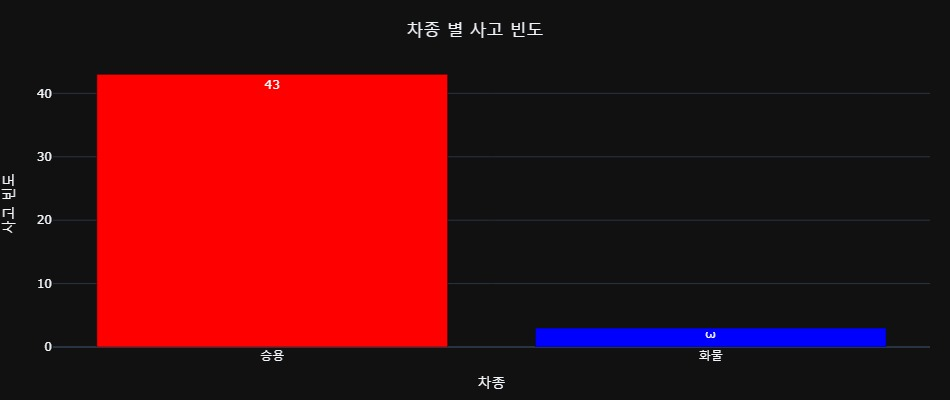

In [37]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '통영대전선/중부선') & (t1_cd.get('accidents')['c_관찰구간'] == '274, 274.9')]
workdata_sr = workdata_df['c_차종'].value_counts()
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='차종 별 사고 빈도', color=workdata_sr.values,
             labels={'index': '차종', 'y': '사고 빈도'})
fig.update_layout(px_layout)
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.10.3 주중·주말 사고 빈도


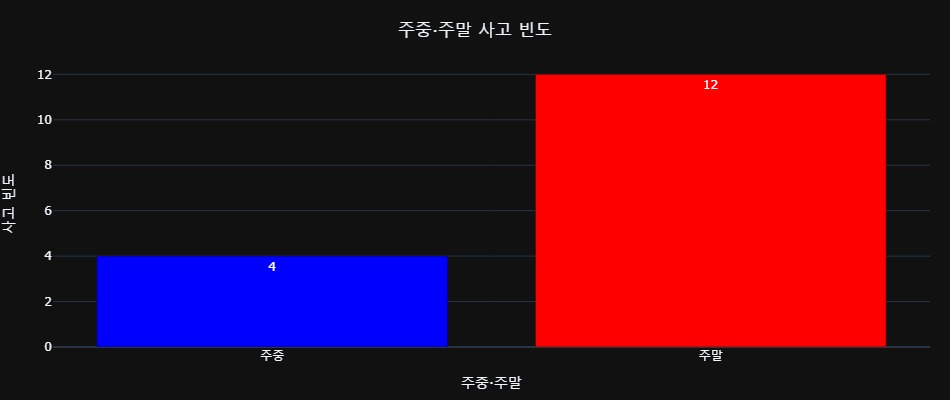

In [38]:
# 데이터 준비
workdata_df = t1_cd.get('accidents')[(t1_cd.get('accidents')['c_도로명'] == '통영대전선/중부선') & (t1_cd.get('accidents')['c_관찰구간'] == '274, 274.9')]
workdata_sr = workdata_df['c_주중주말'].value_counts()
workdata_sr['주중'] /= 5
workdata_sr['주말'] /= 2
# 시각화
fig = px.bar(workdata_sr, x=workdata_sr.index, y=workdata_sr.values, text=workdata_sr.values, title='주중·주말 사고 빈도', color=workdata_sr.values,
             labels={'index': '주중·주말', 'y': '사고 빈도'})
fig.update_layout(px_layout, xaxis={'categoryorder': 'array', 'categoryarray': ['주중', '주말']})
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

##### 3.2.10.4 원인 분석 및 개선안

현상 요약
- 승용, 주말의 사고 빈도가 높은 구간입니다.

원인 분석
- 교량 : 초평1교, 초평2교가 있는 구간입니다.
- 곡선 : 곡선 구간입니다.

개선안
- 주의 안내판을 강조합니다.

## 4 번외

### 4.1 한국도로공사 문자 정보에 귀 기울이자!
> 전체 사고 **9,600건** 중 **463건 (4.82%)은** 사고 전에 이미 해당 구간에 문자 정보가 발송되었습니다.
- 사고 완료 이전 **1.5시간 ~ 0.5시간**, 해당 구간 주의 문자 정보 발송 여부 기준


#### 4.1.1 발생 사고와 문자 정보 비교


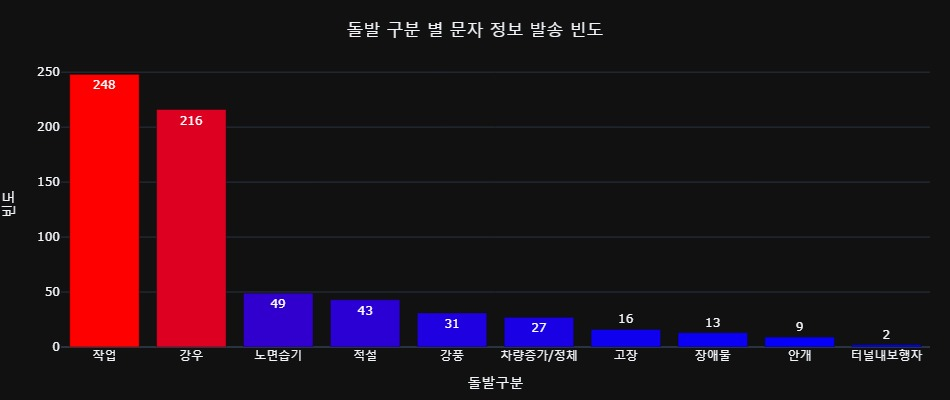

In [39]:
# 데이터 준비
def get_sms_sent_by_accident(accident_sr):
    dt_start = accident_sr['c_발생일시'] - timedelta(minutes=90)
    dt_end = accident_sr['c_발생일시'] - timedelta(minutes=30)
    sms_sent_df = t1_cd.get('sms_sent')[(t1_cd.get('sms_sent')['노선번호'] == accident_sr['노선번호'])
                                        & (t1_cd.get('sms_sent')['c_이정시작'] <= accident_sr['c_이정중심'])
                                        & (accident_sr['c_이정중심'] <= t1_cd.get('sms_sent')['c_이정종료'])
                                        & (dt_start <= t1_cd.get('sms_sent')['c_발생일시'])
                                        & (t1_cd.get('sms_sent')['c_발생일시'] <= dt_end)
                                        & (t1_cd.get('sms_sent')['기점종점방향구분명'] == accident_sr['기점종점방향구분명'])]
    return sms_sent_df

sms_ahead_df = None
workdata_df = t1_cd.get('accidents').copy()
workdata_df = workdata_df[workdata_df['c_발생일시'] >= workdata_df['c_발생일시'].min() + timedelta(minutes=90)]
for idx, accident_sr in workdata_df.iterrows():
    sms_sent_df = get_sms_sent_by_accident(accident_sr)
    if len(sms_sent_df):
        # 사고 발생 전 발송 된 주의 문자가 있습니다!
        workdata_df.loc[idx, '사전주의알림'] = True
        sms_ahead_df = pd.concat([sms_ahead_df, sms_sent_df], ignore_index=True) if isinstance(sms_ahead_df, pd.DataFrame) else sms_sent_df
# 시각화
sms_ahead_df = sms_ahead_df['돌발진행상태구분명'].value_counts().reset_index().rename(columns={'돌발진행상태구분명': '빈도', 'index': '돌발구분'})
sms_ahead_df
fig = px.bar(sms_ahead_df, x='돌발구분', y='빈도', text='빈도', title='돌발 구분 별 문자 정보 발송 빈도', color='빈도', color_continuous_scale='bluered')
fig.update_layout(px_layout)
fig.update_xaxes(categoryorder='total descending')
CustomUtils.display_htmls(CustomUtils.jpeg_binary_to_img_src(fig.to_image(format='jpg')))

#### 4.1.2 사례

In [40]:
# 사례 1
alerted_accident_sr = workdata_df[workdata_df['사전주의알림'] == True].iloc[0]
alerted_sms_df = get_sms_sent_by_accident(alerted_accident_sr).T
CustomUtils.display_htmls('<h2>발생한 사고 사례 1</h2>', '<h2>사고 전 발송된 문자 정보</h2>')
CustomUtils.display_htmls(alerted_accident_sr.to_frame().to_html(), alerted_sms_df.to_html())

발생한 사고 사례 1 사고 전 발송된 문자 정보

,32
발생일자,20200801
발생시간,14:21:55
노선번호,0352
기점종점방향구분명,남이방향
구간,진천터널부근(275K)
문자내용,(1차로)승용차 사고처리완료
돌발진행상태구분명,사고
돌발진행상태구분코드,2
c_발생일시,2020-08-01 14:21:55
c_요일,토요일


In [41]:
# 사례 2
alerted_accident_sr = workdata_df[workdata_df['사전주의알림'] == True].iloc[1]
alerted_sms_df = get_sms_sent_by_accident(alerted_accident_sr).T
CustomUtils.display_htmls('<h2>발생한 사고 사례 2</h2>', '<h2>사고 전 발송된 문자 정보</h2>')
CustomUtils.display_htmls(alerted_accident_sr.to_frame().to_html(), alerted_sms_df.to_html())

발생한 사고 사례 2 사고 전 발송된 문자 정보

,36
발생일자,20200801
발생시간,15:40:45
노선번호,0010
기점종점방향구분명,서울방향
구간,청주부근(303.5K)
문자내용,(2차로) 승용차 관련 사고처리완료
돌발진행상태구분명,사고
돌발진행상태구분코드,2
c_발생일시,2020-08-01 15:40:45
c_요일,토요일


#### 4.1.3 문자정보 제공 서비스 이용 방법

![도로공사 문자정보 제공 서비스](https://jhs-public.s3.ap-northeast-2.amazonaws.com/dacon-2108/%EB%8F%84%EB%A1%9C%EA%B3%B5%EC%82%AC%EB%AC%B8%EC%9E%90%EC%84%9C%EB%B9%84%EC%8A%A4.png)
- 출발전 출발지IC명과 도착지IC명을 작성하여 1588-2504로 전송하면 고객의 핸드폰 번호로 교통상황에 대한 문자를 받을 수 있습니다.
- 자세한 내용은 [공식 웹사이트](http://www.ex.co.kr/site/com/pageProcess.do?selDpPgNm=menuno=100208000&dirNm=portal)를 참고하시면 됩니다.

## 5 결론

우리는 이번 프로젝트를 시작할 때 사고 다발 구간의 공통점들을 찾고 개선안을 제시하는 것을 목표로 하였습니다.<br>
그러나 실제 구간 별 분석을 진행 할 수록 구간들은 서로 공통점 보다는 (버스전용차로 시행 지점 등) 고유하거나 차별적인 특징이 있음을 발견하게 되었습니다.<br>
이에 구간들의 공통점을 유추하는 대신, 각 구간별 맞춤형 개선안을 제시하고자 노력하였습니다.

우리는 이번 분석의 결과로 다음을 제안합니다.

- 경부선 오산나들목 인근 평일 버스전용차로 시작점의 변경을 제안합니다.
- 수도권제1순환선 장수나들목 인근 교통량 분산 유도 및 본선 우측 1개 차선의 합류 우선 차선 배정을 제안합니다.
- 남해선(순천부산) 창원제1터널의 교통량을 분산 할 신규 우회로의 건설을 제안합니다.
- 사고 감소에 기여할 수 있는 도로공사 문자정보와 유사한 정보를 제공하는 고속도로교통정보 앱의 홍보 강화를 제안합니다.

감사합니다.